# SET UP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import zipfile
import os
import shutil
import glob as gb
import pathlib
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
import pickle

# Preprocessing
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,PolynomialFeatures,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from scipy.stats import randint

# Metrics
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# Machine learning model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# GET AND ORGANIZE DATA

In [3]:
# Now upload the file "kaggle.json" file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vukimhuong","key":"7c4009a9db4a8ee3f17c8132606cfb37"}'}

In [4]:
# Install kaggle package
!pip install --upgrade --force-reinstall --no-deps kaggle

# Ensure kaggle.json is in the location ~/.kaggle/kaggle.json to use the API.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Use with option -p to choose the destination
!kaggle datasets download -d jmmvutu/summer-products-and-sales-in-ecommerce-wish -p /content/MyDrive/DATASET/SUMMERS_PRODUCTS

# Now you can Unzip it!
!unzip -q /content/MyDrive/DATASET/SUMMERS_PRODUCTS/summer-products-and-sales-in-ecommerce-wish.zip -d /content/MyDrive/DATASET/SUMMERS_PRODUCTS

     |████████████████████████████████| 58 kB 5.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=804dc315231f28a6f18dfc70fc59a58e5cd03cf0c1712a60bf85dbf540802916
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
 82% 36.0M/44.0M [00:00<00:00, 52.9MB/s]
100% 44.0M/44.0M [00:00<00:00, 52.5MB/s]


# EXPLORE DATASET

## Overview

In [5]:
# Load the csv file 
summer_1 = pd.read_csv('/content/MyDrive/DATASET/SUMMERS_PRODUCTS/keywords-popular_2021-04/mainstream/summer.csv')
df_2020 = pd.read_csv('/content/MyDrive/DATASET/SUMMERS_PRODUCTS/keywords-popular_2021-04/mainstream/2020.csv')
df_2021 = pd.read_csv('/content/MyDrive/DATASET/SUMMERS_PRODUCTS/keywords-popular_2021-04/mainstream/2021.csv')
bodysuit = pd.read_csv('/content/MyDrive/DATASET/SUMMERS_PRODUCTS/keywords-popular_2021-04/mainstream/bodysuit.csv')
dress = pd.read_csv('/content/MyDrive/DATASET/SUMMERS_PRODUCTS/keywords-popular_2021-04/mainstream/dress.csv')
beachwear = pd.read_csv('/content/MyDrive/DATASET/SUMMERS_PRODUCTS/keywords-popular_2021-04/mainstream/beachwear.csv')
wear = pd.read_csv('/content/MyDrive/DATASET/SUMMERS_PRODUCTS/keywords-popular_2021-04/mainstream/wear.csv')
boot = pd.read_csv('/content/MyDrive/DATASET/SUMMERS_PRODUCTS/keywords-popular_2021-04/mainstream/boot.csv')
summer = pd.concat([summer_1,df_2020, df_2021,
                    bodysuit, dress,
                    beachwear, wear,boot], axis=0)

In [6]:
summer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7206 entries, 0 to 897
Data columns (total 44 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   title                                7189 non-null   object 
 1   title_orig                           6536 non-null   object 
 2   discount_price                       6536 non-null   float64
 3   discount_price_currency              6536 non-null   object 
 4   retail_price                         6536 non-null   float64
 5   retail_price_currency                6536 non-null   object 
 6   discount_price_in_original_currency  6536 non-null   float64
 7   nb_cart_orders_approx                6536 non-null   float64
 8   nb_units_purchased_approx            0 non-null      float64
 9   uses_ad_boosts                       0 non-null      float64
 10  rating                               6536 non-null   float64
 11  rating_count                   

In [7]:
summer.describe()

,discount_price,retail_price,discount_price_in_original_currency,nb_cart_orders_approx,nb_units_purchased_approx,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,tags,product_variation_inventory,shipping_option_price,countries_shipped_to,inventory_total,merchant_rating_count,merchant_rating,merchant_has_profile_picture,merchant_profile_picture
count,6536.000000,6536.000000,6536.000000,6536.000000,0.0,0.0,6536.000000,6536.000000,5131.000000,5131.000000,5131.000000,5131.000000,5131.000000,0.0,0.0,0.0,0.0,0.0,6536.000000,6536.000000,0.0,6536.000000,6.536000e+03,6536.000000,0.0,0.0
mean,33.614357,56.523109,39.987078,1447.454865,NaN,NaN,4.193478,324.587209,211.994933,78.435977,53.974079,25.311050,43.751510,NaN,NaN,NaN,NaN,NaN,35.521879,4.902552,NaN,47.827570,1.669549e+04,4.115056,NaN,NaN
std,358.672215,376.880289,434.850552,5298.057110,NaN,NaN,0.644707,1118.488408,633.589423,241.991963,182.351585,88.939546,141.122645,NaN,NaN,NaN,NaN,NaN,20.645501,4.154193,NaN,9.117348,7.598008e+04,0.285625,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,1.000000,0.000000e+00,1.000000,NaN,NaN
25%,7.000000,8.000000,8.000000,10.000000,NaN,NaN,3.796474,2.000000,9.000000,3.000000,2.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,10.000000,2.000000,NaN,50.000000,5.880000e+02,3.941833,NaN,NaN
50%,11.000000,15.000000,13.000000,10.000000,NaN,NaN,4.171429,33.000000,36.000000,12.000000,7.000000,3.000000,7.000000,NaN,NaN,NaN,NaN,NaN,50.000000,3.000000,NaN,50.000000,2.484000e+03,4.123006,NaN,NaN
75%,19.000000,36.000000,20.000000,1000.000000,NaN,NaN,4.893939,195.000000,154.000000,54.000000,35.000000,16.000000,31.000000,NaN,NaN,NaN,NaN,NaN,50.000000,6.000000,NaN,50.000000,1.092250e+04,4.277513,NaN,NaN
max,12256.000000,12256.000000,14859.000000,100000.000000,NaN,NaN,5.000000,26052.000000,13885.000000,4618.000000,3755.000000,2041.000000,2768.000000,NaN,NaN,NaN,NaN,NaN,50.000000,80.000000,NaN,50.000000,3.464509e+06,5.000000,NaN,NaN


In [8]:
corr_matrix = summer.corr()
corr_matrix['nb_cart_orders_approx'].sort_values(ascending=False)

nb_cart_orders_approx                  1.000000
rating_count                           0.900905
rating_three_count                     0.894499
rating_four_count                      0.885747
rating_two_count                       0.866528
rating_five_count                      0.865475
rating_one_count                       0.840754
merchant_rating_count                  0.221508
inventory_total                        0.061007
product_variation_inventory            0.017380
merchant_rating                        0.005410
discount_price_in_original_currency   -0.018988
discount_price                        -0.019068
retail_price                          -0.025071
shipping_option_price                 -0.118660
rating                                -0.119602
nb_units_purchased_approx                   NaN
uses_ad_boosts                              NaN
badges_count                                NaN
badge_local_product                         NaN
badge_product_quality                   

In [9]:
summer.shape

(7206, 44)

- The data set has 7206 rows and 44 columns.
- It has 18 categorical columns and 26 numerical columns.

In [10]:
summer.head()

,title,title_orig,discount_price,discount_price_currency,retail_price,retail_price_currency,discount_price_in_original_currency,nb_cart_orders_approx,nb_units_purchased_approx,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,tags,product_color,product_variation_size_id,product_variation_inventory,shipping_option_name,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,urgency_text,origin_country,merchant_title,merchant_name,merchant_info_subtitle,merchant_rating_count,merchant_rating,merchant_id,merchant_has_profile_picture,merchant_profile_picture,product_url,product_picture,product_id
0,Simple Summer Beach Vacation Multicouche 925 S...,Simple Summer Beach Vacation Multilayer 925 St...,3.11,EUR,4.0,EUR,3.77,5000.0,NaN,NaN,4.020408,539.0,303.0,92.0,57.0,26.0,61.0,NaN,NaN,NaN,NaN,NaN,white,NaN,50.0,Livraison standard,1.0,False,NaN,50.0,NaN,NaN,CN,Angol,angol,"94 % avis positifs (74,181 notes)",74181.0,4.476591,5a4f21f26ecee00df04a6d3c,NaN,NaN,https://www.wish.com/c/5d25b24efc082072e2af3471,https://canary.contestimg.wish.com/api/webimag...,5d25b24efc082072e2af3471
1,Bendis Women's Pattaya Lovely Long Summer Dres...,Bendis Women's Pattaya Lovely Long Summer Dres...,42.00,EUR,42.0,EUR,50.00,0.0,NaN,NaN,5.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,red,free,2.0,Livraison standard,17.0,False,NaN,2.0,NaN,NaN,KR,atcmart,atcmart,67 % avis positifs (6 notes),6.0,3.833333,5fe2119d5265268f81dec682,NaN,NaN,https://www.wish.com/c/5ff3dde8c34b780048c7b0b9,https://canary.contestimg.wish.com/api/webimag...,5ff3dde8c34b780048c7b0b9
2,2021 nouveau été hommes polos chemise été mode...,2021 New Summer Men's Polos Shirt Summer Fashi...,4.79,EUR,44.0,EUR,5.81,1000.0,NaN,NaN,3.571429,42.0,16.0,9.0,5.0,7.0,5.0,NaN,NaN,NaN,NaN,NaN,grey&white,3xs,1.0,Livraison standard,1.0,False,NaN,50.0,NaN,NaN,US,DDFGb,ddfgb,(157 notes),157.0,4.006369,5e695b405c6818fdeccfad33,NaN,NaN,https://www.wish.com/c/600687ecc9d71b0318749e95,https://canary.contestimg.wish.com/api/webimag...,600687ecc9d71b0318749e95
3,Gilet d'entraînement d'été en dentelle sans ma...,5 Colors Fashion Women Sleeveless Lace Tops Se...,5.00,EUR,5.0,EUR,6.00,10000.0,NaN,NaN,3.906273,1355.0,648.0,285.0,197.0,97.0,128.0,NaN,NaN,NaN,NaN,NaN,grey,s,50.0,Livraison standard,2.0,False,NaN,50.0,NaN,NaN,CN,Adrea boutique,adreaboutique,"(15,616 notes)",15616.0,4.063140,55f7c64b3a698c4749f3bccf,NaN,NaN,https://www.wish.com/c/5bebc4a90269f2172b1af950,https://canary.contestimg.wish.com/api/webimag...,5bebc4a90269f2172b1af950
4,XS-8XL Plus La Taille Vêtements De Mode Robes ...,XS-8XL Plus Size Fashion Clothes Women's Dress...,4.69,EUR,5.0,EUR,5.68,1000.0,NaN,NaN,3.505495,273.0,103.0,54.0,46.0,18.0,52.0,NaN,NaN,NaN,NaN,NaN,yellow,xs,3.0,Livraison standard,1.0,False,NaN,50.0,NaN,NaN,CN,mynewsoul,mynewsoul,"85 % avis positifs (2,034 notes)",2034.0,4.002950,580f361ff6978b4fdba4b112,NaN,NaN,https://www.wish.com/c/5e0450861f26761e566fee35,https://canary.contestimg.wish.com/api/webimag...,5e0450861f26761e566fee35


## Clear data

### Drop data

**Unlogic data - product has retail_price = 0**

In [11]:
unlogic_data = list(summer[summer['retail_price'] == 0].index)

In [12]:
summer.drop(index=unlogic_data, inplace=True)

**The unnecessary data**

Title

In [13]:
summer.drop(columns=['title_orig', 'title'], inplace = True, axis = 1)

Price currency

In [14]:
summer.drop(['discount_price_currency', 'retail_price_currency',
             'discount_price_in_original_currency'], inplace = True, axis = 1)

Merchant

In [15]:
summer.drop(['merchant_has_profile_picture', 'merchant_id',
             'merchant_title','merchant_name', 'merchant_info_subtitle'], inplace = True, axis = 1)

Product

In [16]:
summer.drop(['product_url','product_picture','product_id'], inplace = True, axis = 1)

Shipping

In [17]:
summer.drop(['shipping_is_express'], inplace = True, axis = 1)

Rating

In [18]:
summer.drop(['rating_count','rating', 'merchant_rating', 'merchant_rating_count',
             'rating_five_count', 'rating_four_count', 
             'rating_three_count','rating_two_count', 'rating_one_count'], inplace = True, axis = 1)

### Missing values

**Data columns has Nan more than 200**

In [19]:
summer.isna().sum()

discount_price                  667
retail_price                    667
nb_cart_orders_approx           667
nb_units_purchased_approx      7150
uses_ad_boosts                 7150
badges_count                   7150
badge_local_product            7150
badge_product_quality          7150
badge_fast_shipping            7150
tags                           7150
product_color                  1775
product_variation_size_id      1320
product_variation_inventory     667
shipping_option_name            667
shipping_option_price           667
countries_shipped_to           7150
inventory_total                 667
has_urgency_banner             5515
urgency_text                   5515
origin_country                  676
merchant_profile_picture       7150
dtype: int64

In [20]:
drop_large_nan = list(summer.loc[:,summer.isna().sum()> 5000].columns)

In [21]:
drop_large_nan

['nb_units_purchased_approx',
 'uses_ad_boosts',
 'badges_count',
 'badge_local_product',
 'badge_product_quality',
 'badge_fast_shipping',
 'tags',
 'countries_shipped_to',
 'has_urgency_banner',
 'urgency_text',
 'merchant_profile_picture']

In [22]:
summer.drop(drop_large_nan,inplace=True, axis=1)

In [23]:
def missing_data(summer):
    palette = sns.color_palette("Blues", n_colors = 30)
    palette.reverse()
    columns_missing = summer.columns[summer.isna().sum() >0]
    missing_percentage = (summer[columns_missing].isna().sum() / summer.shape[0]).sort_values(ascending=False)*100
    plt.figure(figsize=(30,10))
    sns.set_theme(style="whitegrid")
    sns.barplot(x = missing_percentage, y = missing_percentage.index, palette=palette)
    plt.title('% NULL values in each columns')

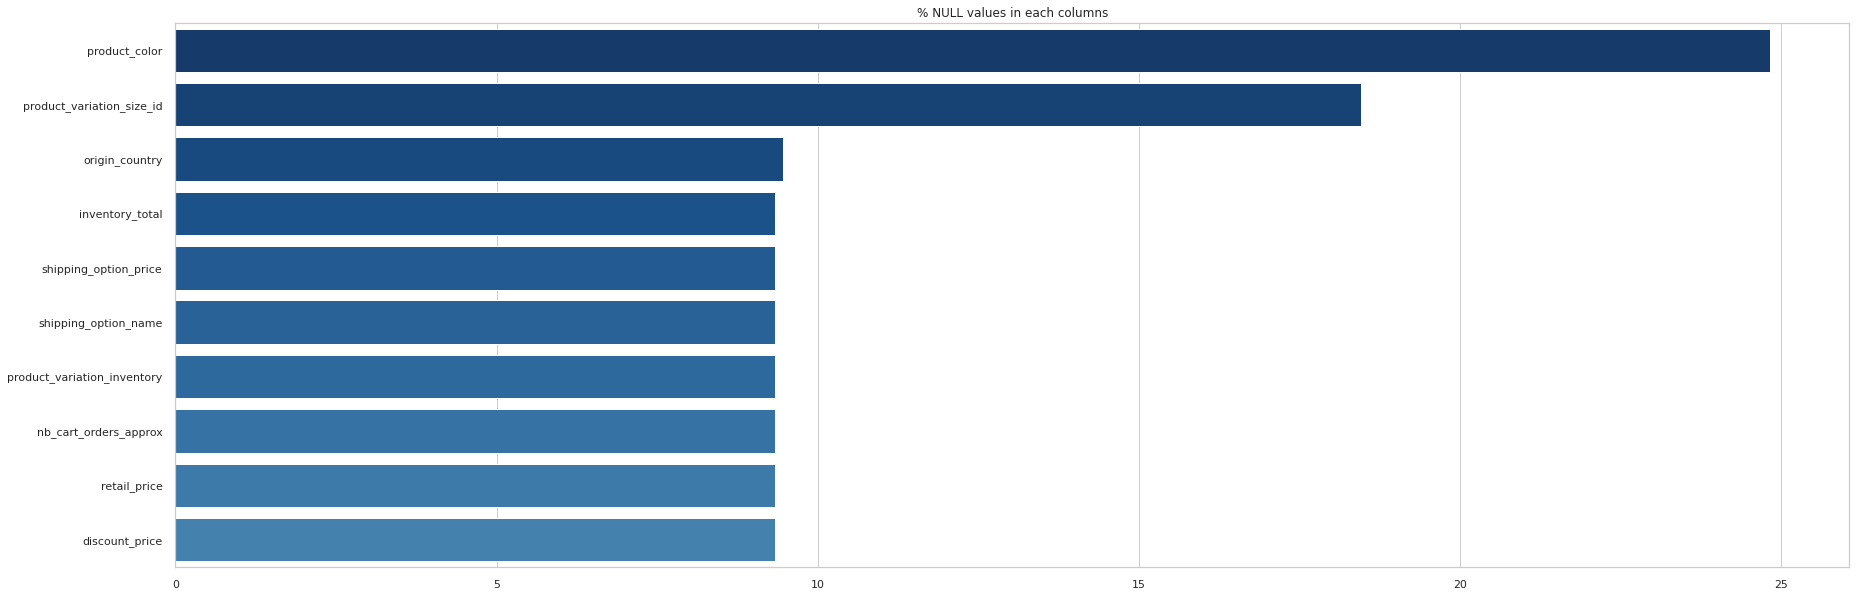

In [24]:
missing_data(summer)

**Product_color**: fill NaN into Others

In [25]:
summer['product_color'].fillna(value = 'Others', inplace = True)

**Product_variation_size_id** : fill NaN into Others

In [26]:
summer['product_variation_size_id'].fillna(value='Others', inplace = True)

**Origin_country** : fill NaN into Others

In [27]:
summer['origin_country'].fillna(value='Others', inplace = True)

In [28]:
summer.isna().sum()

discount_price                 667
retail_price                   667
nb_cart_orders_approx          667
product_color                    0
product_variation_size_id        0
product_variation_inventory    667
shipping_option_name           667
shipping_option_price          667
inventory_total                667
origin_country                   0
dtype: int64

In [29]:
summer.dropna(axis=0, inplace=True)

### Drop duplicated

In [30]:
summer.drop_duplicates(inplace=True)

### Detect oulier

In [31]:
summer.describe()

,discount_price,retail_price,nb_cart_orders_approx,product_variation_inventory,shipping_option_price,inventory_total
count,6065.000000,6065.000000,6065.000000,6065.000000,6065.000000,6065.000000
mean,35.222575,59.247657,1472.036439,34.796538,4.981284,47.712613
std,372.277130,389.793125,5421.925880,20.890021,4.233939,9.340118
min,0.720000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,7.000000,8.000000,10.000000,9.000000,2.000000,50.000000
50%,11.000000,16.000000,10.000000,50.000000,3.000000,50.000000
75%,19.000000,39.000000,1000.000000,50.000000,7.000000,50.000000
max,12256.000000,12256.000000,100000.000000,50.000000,80.000000,50.000000


#### Discount price & retail_price

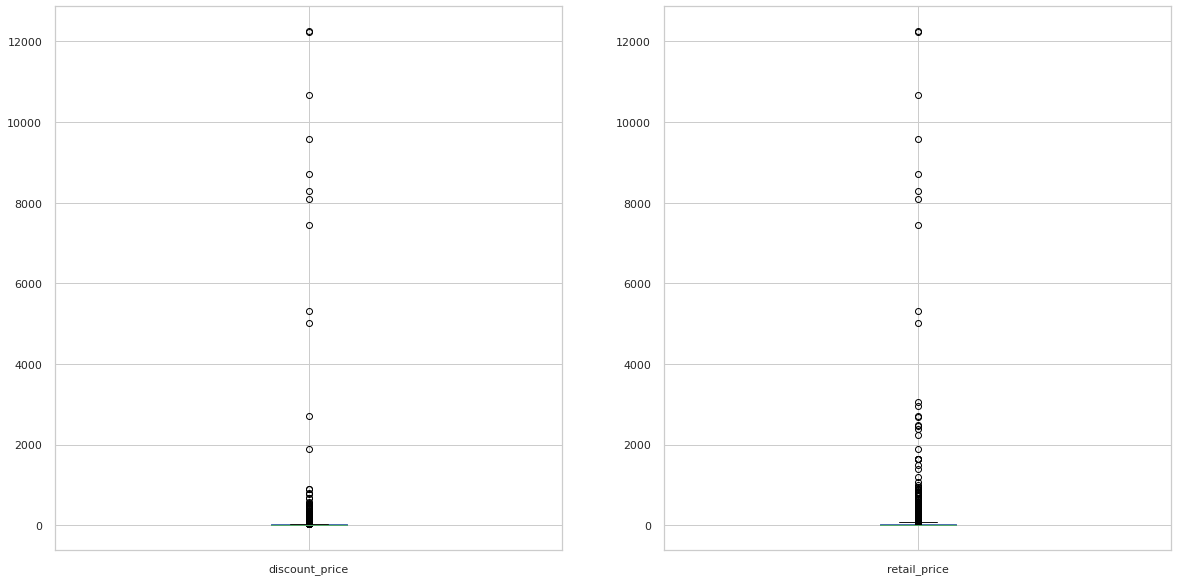

In [32]:
# Visualize with boxplot
plt.subplots(2,3, figsize=(20,10))

plt.subplot(121)
summer['discount_price'].plot(kind='box')

plt.subplot(122)
summer['retail_price'].plot(kind='box')

plt.show()

In [33]:
summer.head()

,discount_price,retail_price,nb_cart_orders_approx,product_color,product_variation_size_id,product_variation_inventory,shipping_option_name,shipping_option_price,inventory_total,origin_country
0,3.11,4.0,5000.0,white,Others,50.0,Livraison standard,1.0,50.0,CN
1,42.00,42.0,0.0,red,free,2.0,Livraison standard,17.0,2.0,KR
2,4.79,44.0,1000.0,grey&white,3xs,1.0,Livraison standard,1.0,50.0,US
3,5.00,5.0,10000.0,grey,s,50.0,Livraison standard,2.0,50.0,CN
4,4.69,5.0,1000.0,yellow,xs,3.0,Livraison standard,1.0,50.0,CN


## Data engineering

In [34]:
summer['nb_cart_orders_approx'] = summer['nb_cart_orders_approx'].apply(lambda x: 100 if x <= 100 else x)

In [35]:
colour_data = {
       'white&blue': 'blue', 'tiffanyblue': 'blue', 'red&blue': 'blue', 'darkblue': 'blue', 'blue&stripe': 'blue',
       'royalblue': 'blue', 'seablue': 'blue', 'cyan&blue': 'blue',
       'oceanblue': 'blue', 'bone&blue': 'blue', 'aquablue': 'blue', 
       'bluesapphire': 'blue', 'turquoiseblue': 'blue', 'sailorblue': 'blue',
       'transparent&blue': 'blue', 'blackblue': 'blue',
       'whiteblue': 'blue',  'lakeblue' : 'blue',
       'navyblue&white': 'blue', 'bluecellular': 'blue', 'bluesky': 'blue',
        'blue&multicolor': 'blue',
       'denimblue': 'blue', 'deepblue': 'blue', 'angelblue': 'blue', 'blue-green': 'blue',
      'bluepenguin': 'blue', 'bluewash': 'blue', 'sapphireblue': 'blue',
        'brightblue': 'blue', 'aquaticblue': 'blue',
       'glacierblue': 'blue', 'tealblue': 'blue', 'navyblue/yellow': 'blue',
       'blueplaid': 'blue', 'peacockblue': 'blue', 
       'babyblue': 'blue', 'multicolor&blue': 'blue',
       'metallicpiping/bluefilter': 'blue',
       'alaskablue': 'blue', 'gray&blue-green': 'blue', 'bluestripe': 'blue',
       'beigelightblue': 'blue', 'queenblue': 'blue', 'bluediamond': 'blue', 'alaskanblue': 'blue',
       'bluecar': 'blue', 'bellflowerblue': 'blue', 'bluegreen': 'blue', 'lightskyblue': 'blue',
       'bluesilver': 'blue', 'bluestars': 'blue', 'bluegray': 'blue', 'blue&pink': 'blue',
       'darkslateblue': 'blue', 'prussianblue': 'blue', 
       'grayblue': 'blue', 'blueberry': 'blue', 'acidblue': 'blue',
    

       'armygreen':'green', 'lightgreen':'green', 'blue&green':'green', 'green&blue':'green',
       'yellow&green':'green', 'silver&green':'green', 'militarygreen':'green', 'darkgreen':'green',
       'grassgreen':'green', 'clovergreen':'green', 'limegreen':'green', 'tealgreen':'green', 'mintgreen':'green',
       'camouflagegreen':'green','armygreen&camouflage':'green',
       'camouflage&armygreen':'green', 'greenbottle':'green', 'lakegreen':'green', 'brightgreen':'green',
       'green&grey':'green', 'olivegreen':'green', 'green&green':'green', 'springgreen':'green',
       'coolblack&green':'green', 'kellygreen':'green', 'green&rosered':'green',
       'reflectivegreen/concrete':'green', 'oasisgreen':'green',
       'green/white':'green', 'acidgreen':'green', 'greencamo':'green', 'hotpink&green':'green',
       'applegreen':'green', 'pink&green&blue':'green', 'grey&green':'green',
       'black&lightgreen':'green', 'turquoisegreen':'green', 'gray&blue-green':'green',
       'darkarmygreen':'green', 'bluegreen':'green', 'charlestongreen':'green', 'purple&green':'green',
       'green&purple':'green', 'fluorescentgreen':'green', 'green&red':'green', 'green&white':'green',
       'green&brick':'green', 'sweetgreen/black':'green', 'green&silver':'green', 'bottlegreen':'green',
       'forestgreen':'green', 'blue-green&red':'green', 'neongreen':'green', 'camogreen':'green',


       'orange&yellow':'yellow', 'blue&yellow':'yellow', 'yellow&pink':'yellow',
       'black&yellow':'yellow', 'yellow&green':'yellow', 'yellowgold':'yellow', 'lightyellow':'yellow',
       'gold&yellow':'yellow', 'bananayellow':'yellow', 'yellowcamouflage':'yellow',
       'darkyellow':'yellow', 'yellow/white':'yellow', 'yellow/gold':'yellow',
       'white&yellow':'yellow', 'navyblue/yellow':'yellow', 'goldenyellow':'yellow',
       'fluorescentyellow':'yellow', 'grey&yellow':'yellow', 'green&yellow':'yellow', 'bronzeyellow':'yellow',
       'darkblue&yellow':'yellow', 'winered&yellow':'yellow', 'yellow&grey':'yellow', 'pink&yellow':'yellow',
       'earthyellow':'yellow', 'white/yellow':'yellow',

       'rosered':'red', 'multicolored':'red', 'winered':'red', 'red&blue':'red',
       'red&black':'red', 'watermelonred':'red', 'darkred':'red', 'rubyred':'red', 'red&pink':'red',
       'silver&red':'red', 'garnetred':'red', 'bordeauxred':'red', 'black&red':'red', 'mattered':'red',
       'brickred':'red', 'red&white':'red', 'blue&red':'red', 'gold&red':'red', 'red&gold':'red',
       'navy&red':'red', 'rose&red':'red', 'redplaid':'red',
       'red&red':'red', 'black/red':'red', 'red&grey':'red', 'navyblue&red':'red', 'redblack':'red',
       'black&rosered':'red', 'redwhite':'red', 'red&green':'red', 'yellow&red':'red',
       'tangored':'red', 'floral&red':'red',
       'metallicred':'red', 'leopardprint&red':'red', 'barnred':'red', 'brightred':'red',
       'vintagered':'red', 'purplishred':'red', 'carminered/black':'red', 'lightred':'red',
       'grey&red':'red', 'blackredassorted':'red', 'red&flame':'red', 'darkgray&red':'red',
       'blackred':'red', 'purple&red':'red', 'redhot':'red', 'darkblue&rosered':'red', 'redwood':'red',
       'redpunch':'red', 'graphicblackred':'red', 'red&wine':'red', 'brown&red':'red',
       'winered&yellow':'red', 'cardinalred':'red',
       'burgundysunsetheatheredrugbystripe':'red', 'red&khaki':'red', 'red&darkblue':'red',
       'green&red':'red', 'deepred':'red', 'redorange':'red', 'blue-green&red':'red', 'glossyred':'red',
       'whitered':'red', 'red/chrome':'red',

       'darkgrey': 'grey', 'butterfly&grey': 'grey', 'blue&grey': 'grey', 'lightgrey': 'grey',
       'silvergrey': 'grey', 'navygrey': 'grey', 'blackgrey': 'grey',
       'greysnakeskinprint': 'grey', 
       'heathergrey': 'grey', 'sportgrey': 'grey', 'grey&white': 'grey', 'black&darkgrey': 'grey',
       'grey&orange': 'grey', 'darkgrey&red': 'grey', 'rose/grey': 'grey', 'lightgrey&black': 'grey',
       'grey&camouflage': 'grey',
       'grey&green': 'grey', 'icegrey': 'grey','purple&grey': 'grey', 'coolgrey': 'grey',

        'coffee': 'brown', 'camel': 'brown', 'tan': 'brown', 
        'offwhite': 'white', 'ivory': 'white', 'nude': 'white',
        'lightpink': 'pink', 'dustypink':'pink', 'rosegold': 'pink',
        'lightpurple': 'purple', 'coolblack': 'black', 'apricot': 'orange', 'offblack': 'black'}


def update_color(col):
    if colour_data.get(col, False):
        return colour_data.get(col)
    elif '&' in col:
        return 'dual'
    elif col in colour_data.values():
        return col
    else:
        return 'other'

summer['product_color'] =  summer['product_color'].apply(update_color)

In [36]:
summer['product_variation_size_id'] = summer['product_variation_size_id'].replace('2xl', 'xl')
summer['product_variation_size_id'] = summer['product_variation_size_id'].replace('3xl', 'xl')
summer['product_variation_size_id'] = summer['product_variation_size_id'].replace('4xl', 'xl')
summer['product_variation_size_id'] = summer['product_variation_size_id'].replace('5xl', 'xl')
summer['product_variation_size_id'] = summer['product_variation_size_id'].replace('6xl', 'xl')
summer['product_variation_size_id'] = summer['product_variation_size_id'].replace('x   l', 'xl')
summer['product_variation_size_id'] = summer['product_variation_size_id'].replace('sizel', 'l')
summer['product_variation_size_id'] = summer['product_variation_size_id'].replace('size4xl', 'xl')
summer['product_variation_size_id'] = summer['product_variation_size_id'].replace('x   l', 'xl')
summer['product_variation_size_id'] = summer['product_variation_size_id'].replace('1 pc - xl', 'xl')

def size_change(size):
    if size in 'xl,l,s,xs,m,xxl,xxxs,xxxxxl,xxxxl'.split(','):
        return size
    else:
        return 'Other'

summer['product_variation_size_id'] = summer['product_variation_size_id'].apply(size_change)

In [37]:
def origin_country(country):
    if country in 'CN, CA, US, KR, GB, PL, CZ, VN, VE, TR':
        return country
    else:
        return 'Other'

In [38]:
summer['origin_country'] = summer['origin_country'].apply(origin_country)

## Correlation

In [39]:
corr_matrix = summer.corr()

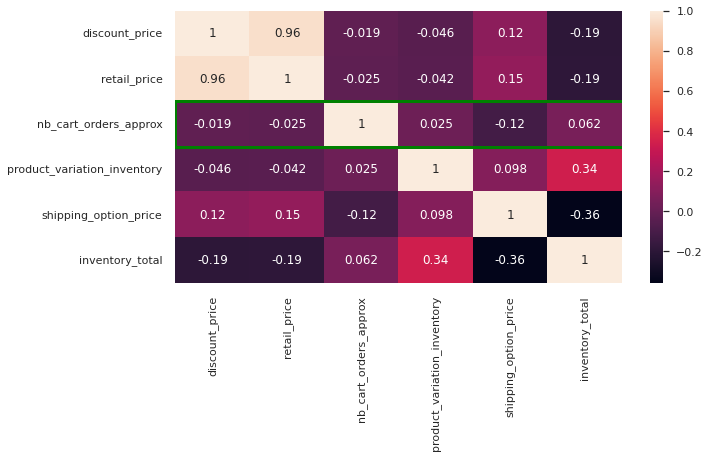

In [40]:
corr_matrix = summer.corr()
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(corr_matrix,
            annot=True,
            ax=ax)
ax.add_patch(plt.Rectangle((0,2),31,1, 
                           fill = False, 
                           edgecolor = 'green', 
                           lw = 3))
plt.show()

# MODEL

In [41]:
summer.describe()

,discount_price,retail_price,nb_cart_orders_approx,product_variation_inventory,shipping_option_price,inventory_total
count,6065.000000,6065.000000,6065.000000,6065.000000,6065.000000,6065.000000
mean,35.222575,59.247657,1534.872218,34.796538,4.981284,47.712613
std,372.277130,389.793125,5405.094992,20.890021,4.233939,9.340118
min,0.720000,1.000000,100.000000,0.000000,0.000000,1.000000
25%,7.000000,8.000000,100.000000,9.000000,2.000000,50.000000
50%,11.000000,16.000000,100.000000,50.000000,3.000000,50.000000
75%,19.000000,39.000000,1000.000000,50.000000,7.000000,50.000000
max,12256.000000,12256.000000,100000.000000,50.000000,80.000000,50.000000


##  Prepare data for ML model

In [42]:
df = summer.copy()

In [43]:
from sklearn.model_selection import train_test_split

x = df.drop('nb_cart_orders_approx',axis=1)
y = df['nb_cart_orders_approx']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [44]:
print('Shape of x train: ',x_train.shape)
print('Shape of y train: ',y_train.shape)
print('Shape of x test: ',x_test.shape)
print('Shape of y test: ',y_test.shape)

Shape of x train:  (4852, 9)
Shape of y train:  (4852,)
Shape of x test:  (1213, 9)
Shape of y test:  (1213,)


## Processing

In [45]:
# numerical columns
numerical = list(x_train.select_dtypes('number').columns) 

# categorical columns
categorical = [col for col in x_train.columns if col not in numerical]

In [46]:
# Define categorical pipeline

cat_pipe = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Define numerical pipeline
num_pipe = Pipeline([
                  ('poly', PolynomialFeatures(degree=1, include_bias=False)), 
                  ('scaler', MinMaxScaler())
                   ])

# Fit column transformer to training data
full_pipeline = ColumnTransformer(transformers=[
                                      ('cat', cat_pipe, categorical),
                                      ('num', num_pipe, numerical)],
                                       remainder='passthrough')

## Select and training model

In [47]:
X_train_transformed = full_pipeline.fit_transform(x_train)

In [48]:
X_test_transformed = full_pipeline.transform(x_test)

In [49]:
def acc_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

In [50]:
DTC = DecisionTreeClassifier(max_depth = 2,random_state = 42)
RFC = RandomForestClassifier(random_state = 42)                     
GBC = GradientBoostingClassifier(random_state = 42)
KNN = KNeighborsClassifier(n_neighbors = 10)
XGB = XGBClassifier()
LGBMC = lgb.LGBMClassifier()

classifiers = [DTC, RFC, XGB, GBC, KNN, LGBMC]

classifiers_names = ['Decision Tree',
                     'Random Forest',
                     'XG Boost',
                     'Gradient Boosting',
                     'KNeighborsClassifier',
                     'LightGBM']
acc_mean = []

for cl in classifiers:
    acc = cross_val_score(estimator= cl, X= X_train_transformed, y= y_train, cv= 5)
    acc_mean.append(acc.mean()*100)
    
acc_df = pd.DataFrame({'Classifiers': classifiers_names,
                       'Accuracy': acc_mean})

acc_df.sort_values('Accuracy',ascending=False)

,Classifiers,Accuracy
2,XG Boost,68.652065
0,Decision Tree,68.239927
3,Gradient Boosting,67.662607
5,LightGBM,67.332880
4,KNeighborsClassifier,67.065073
1,Random Forest,64.736068


## Fine tuning model

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
kfold = KFold(n_splits=5,shuffle=True, random_state=42)

In [52]:
def train_model(model,X_train_transformed,y_train):
  model.fit(X_train_transformed,y_train)
  y_train_pred= model.predict(X_train_transformed)
  rfr_acc = accuracy_score(y_train,y_train_pred)
  print(f"The accuracy is {rfr_acc:.2f}")
  return model

def save_model(best_estimator,filename):
  pickle.dump(best_estimator, open(filename,'wb'))

In [53]:
acc_final= {}

### XG Boost

In [ ]:
#Model
model_xgb = train_model(XGB,X_train_transformed,y_train)
model_xgb.get_params()

The accuracy is 0.70


{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'multi:softprob',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [ ]:
#Randomized Search CV for XGBoost model
n_estimators = randint(low=100, high=400)
max_depth = randint(low=1, high=100)

xgb_random_grid = {'n_estimators': n_estimators,
                    'max_depth' : max_depth,
                    'learning_rate' : [0.01,0.01,0.1]}

xgb_randSearchCV = RandomizedSearchCV(estimator=XGBClassifier(),
                                        param_distributions=xgb_random_grid,
                                        scoring='accuracy',
                                        cv = kfold,
                                        n_iter=20,
                                        n_jobs = -1, verbose = 2)

xgb_randSearchCV.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.01, 0.1],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbd5934a7d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbd5934a710>},
                   scoring='accuracy', verbose=2)

In [ ]:
print(xgb_randSearchCV.best_estimator_)
print("="*80)
print(xgb_randSearchCV.best_params_)
print("="*80)
print(xgb_randSearchCV.best_score_)

XGBClassifier(max_depth=2, n_estimators=214, objective='multi:softprob')
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 214}
0.682599934173506


In [ ]:
# Grid Search CV for XGBoost
xgb_param_grid = {"n_estimators" : list(np.arange(150,155)),
                  "max_depth" :  list(np.arange(145,150)),
                  'learning_rate' :[0.01, 0.01, 0.1]}


xgb_GSC = GridSearchCV(XGBClassifier(),
                       param_grid = xgb_param_grid,
                       scoring = 'accuracy',
                       cv = kfold,
                       n_jobs=-1, verbose=2)

xgb_GSC.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


In [ ]:
print(xgb_GSC.best_estimator_)
print("="*80)
print(xgb_GSC.best_params_)
print("="*80)
print(xgb_GSC.best_score_)

In [91]:
# Predict on test data using final XGB model
xgb_final_model = xgb_GSC.best_estimator_
X_test_prepared = full_pipeline.transform(x_test)

xgb_final_predictions = xgb_final_model.predict(X_test_prepared)

xgb_final_acc = accuracy_score(y_test, xgb_final_predictions)
xgb_final_acc_mean = np.mean(xgb_final_acc)*100   

acc_final['XG Boost'] = xgb_final_acc_mean
xgb_final_acc_mean

66.69414674361089

In [ ]:
print(classification_report(y_test, xgb_final_predictions))

In [ ]:
filename ='/content/gdrive/MyDrive/Final Project/XGBoostClassifier.save_model'
save_model(xgb_final_model,filename)

In [83]:
xgb_final_model = pickle.load(open('/content/gdrive/MyDrive/Final Project/XGBoostClassifier.sav', 'rb'))

In [ ]:
filename ='/content/gdrive/MyDrive/Final Project/XGBoostClassifier.save_model'

In [ ]:
xgb_final_model.save_model(filename)

### Gradient Boosting

In [ ]:
#Model
model_gbc = train_model(GBC,X_train_transformed,y_train)
model_gbc.get_params()

In [ ]:
#Randomized Search CV for Gradient Boost Classifier model

gbc_random_grid = {'learning_rate': [0.001,0.01,0.1],
              'max_depth': randint(low=3, high=15),
              'n_estimators': randint(low=130, high=200)}
              

gbc_randSearchCV = RandomizedSearchCV(estimator=GBC,
                                        param_distributions=gbc_random_grid,
                                        scoring='accuracy',
                                        cv = kfold,
                                        n_iter=20,
                                        n_jobs = -1, verbose = 2)

gbc_randSearchCV.fit(X_train_transformed, y_train)

In [ ]:
print(gbc_randSearchCV.best_estimator_)
print("="*80)
print(gbc_randSearchCV.best_params_)
print("="*80)
print(gbc_randSearchCV.best_score_)

In [ ]:
# Grid Search CV for Gradient Boosting Classifier
gbc_param_grid = {'learning_rate': [0.001],
              'max_depth': np.arange(3,7),
              'n_estimators': np.arange(135,140)}


gbc_GSC = GridSearchCV(GBC,
                       param_grid = gbc_param_grid,
                       scoring = 'accuracy',
                       cv = kfold,
                       n_jobs=-1, verbose=2)

gbc_GSC.fit(X_train_transformed, y_train)

In [ ]:
print(gbc_GSC.best_estimator_)
print("="*80)
print(gbc_GSC.best_params_)
print("="*80)
print(gbc_GSC.best_score_)

In [82]:
# Predict on test data using final Gradient Boost Classifier
gbc_final_model = gbc_GSC.best_estimator_
X_test_prepared = full_pipeline.transform(x_test)

gbc_final_predictions = gbc_final_model.predict(X_test_prepared)

gbc_final_acc = accuracy_score(y_test, gbc_final_predictions)
gbc_final_acc_mean = np.mean(gbc_final_acc)*100  

acc_final['Gradient Boosting'] = gbc_final_acc_mean
gbc_final_acc_mean

67.02390766694147

In [ ]:
print(classification_report(y_test, gbc_final_predictions))

In [ ]:
filename ='/content/gdrive/MyDrive/Final Project/GradientBoostClassifier.sav'
save_model(gbc_final_model,filename)

In [81]:
 gbc_final_model = pickle.load(open('/content/gdrive/MyDrive/Final Project/GradientBoostClassifier.sav', 'rb'))

### Decision Tree

In [56]:
#Model
model_dtc = train_model(DTC,X_train_transformed,y_train)
model_dtc.get_params()

The accuracy is 0.68


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [60]:
#Randomized Search CV for Decision Tree model

dtc_random_grid = {'min_samples_leaf': randint(low=1, high=40),
              'min_samples_split': randint(low=2, high=40)}
              

dtc_randSearchCV = RandomizedSearchCV(estimator=DTC,
                                        param_distributions=dtc_random_grid,
                                        scoring='accuracy',
                                        cv = kfold,
                                        n_iter=20,
                                        n_jobs = -1, verbose = 2)

dtc_randSearchCV.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f566c4e79d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f566c4e7fd0>},
                   scoring='accuracy', verbose=2)

In [62]:
print(dtc_randSearchCV.best_estimator_)
print("="*80)
print(dtc_randSearchCV.best_params_)
print("="*80)
print(dtc_randSearchCV.best_score_)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=12, min_samples_split=36,
                       random_state=42)
{'min_samples_leaf': 12, 'min_samples_split': 36}
0.6823948103241426


In [70]:
# Grid Search CV for Decision Tree
dtc_param_grid = {'min_samples_leaf':  np.arange(12,50),
              'min_samples_split': np.arange(30,40)}

              

dtc_GSC = GridSearchCV(DTC,
                       param_grid = dtc_param_grid,
                       scoring = 'accuracy',
                       cv = kfold,
                       n_jobs=-1, verbose=2)

dtc_GSC.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 380 candidates, totalling 1900 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(max_depth=2, random_state=42),
             n_jobs=-1,
             param_grid={'min_samples_leaf': array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49]),
                         'min_samples_split': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39])},
             scoring='accuracy', verbose=2)

In [71]:
print(dtc_GSC.best_estimator_)
print("="*80)
print(dtc_GSC.best_params_)
print("="*80)
print(dtc_GSC.best_score_)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=12, min_samples_split=30,
                       random_state=42)
{'min_samples_leaf': 12, 'min_samples_split': 30}
0.6823948103241426


In [72]:
# Predict on test data using final Decision Tree
dtc_final_model = dtc_GSC.best_estimator_
X_test_prepared = full_pipeline.transform(x_test)

dtc_final_predictions = dtc_final_model.predict(X_test_prepared)

dtc_final_acc = accuracy_score(y_test, dtc_final_predictions)
dtc_final_acc_mean = np.mean(dtc_final_acc)*100  

acc_final['Decision Tree'] = dtc_final_acc_mean
dtc_final_acc_mean

66.69414674361089

### KNeighbors Classifier

In [ ]:
#Model
model_knn = train_model(KNN,X_train_transformed,y_train)
model_knn.get_params()

In [ ]:
# Randomized Search CV
k_neighbors = list(np.arange(1, 31, 2))
weight_options = ['uniform', 'distance']

knn_random_grid = {"n_neighbors" : k_neighbors,
                   "weights" : weight_options}

knn_randSearchCV = RandomizedSearchCV(estimator=KNN,
                                        param_distributions=knn_random_grid,
                                        scoring='accuracy',
                                        cv = stratified_kfold,
                                        n_jobs = -1, verbose = 2)                   

knn_randSearchCV.fit(X_train_transformed, y_train)

In [ ]:
print(knn_randSearchCV.best_estimator_)
print("="*80)
print(knn_randSearchCV.best_params_)
print("="*80)
print(knn_randSearchCV.best_score_)

In [ ]:
# Grid Search CV
knn_param_grid = {"n_neighbors" : list(np.arange(37,40)),
                  "weights" : ["uniform"],
                  'leaf_size': list(np.arange(30,35))}

knn_GSC = GridSearchCV(KNN,
                       param_grid = knn_param_grid,
                       scoring = 'accuracy',
                       cv = stratified_kfold,
                       n_jobs=-1, verbose=2)

knn_GSC.fit(X_train_transformed, y_train)

In [ ]:
print(knn_GSC.best_estimator_)
print("="*80)
print(knn_GSC.best_params_)
print("="*80)
print(knn_GSC.best_score_)

In [77]:
# Predict on test data using final KNN 
knn_final_model = knn_GSC.best_estimator_
X_test_prepared = full_pipeline.transform(x_test)

knn_final_predictions = knn_final_model.predict(X_test_prepared)

knn_final_acc = accuracy_score(y_test, knn_final_predictions)
knn_final_acc_mean = np.mean(knn_final_acc)*100  

acc_final['KNeighborsClassifier'] = knn_final_acc_mean
knn_final_acc_mean

67.2712283594394

In [ ]:
print(classification_report(y_test, knn_final_predictions))

In [ ]:
filename ='/content/gdrive/MyDrive/Final Project/KNN.sav'
save_model(knn_final_model,filename)

In [76]:
knn_final_model = pickle.load(open('/content/gdrive/MyDrive/Final Project/KNN.sav', 'rb'))

### Random Forest

In [ ]:
#Model
model_rfc = train_model(RFC,X_train_transformed,y_train)
model_rfc.get_params()

In [ ]:
n_estimators = [int(x) for x in np.linspace(5,300,6)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 120, 12)]
max_depth.append(None)
min_samples_leaf = [2, 4, 8, 16]
bootstrap = [True, False]

# Create the random grid
rfc_random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfc_randSearchCV = RandomizedSearchCV(estimator=RFC,
                                        param_distributions=rfc_random_grid,
                                        scoring='accuracy',
                                        cv = kfold,
                                        n_jobs = -1, verbose = 2)

rfc_randSearchCV.fit(X_train_transformed, y_train)

In [ ]:
print(rfc_randSearchCV.best_estimator_)
print("="*80)
print(rfc_randSearchCV.best_params_)
print("="*80)
print(rfc_randSearchCV.best_score_)

In [ ]:
# Grid Search CV for Random Forest Classifier
rfc_param_grid = {"n_estimators" : np.arange(64,68),
                  "max_features" : ['auto'],
                  "max_depth" :  np.arange(40,45),
                  "min_samples_leaf" : [7,8,9]}


rfc_GSC = GridSearchCV(RFC,
                       param_grid = rfc_param_grid,
                       scoring = 'accuracy',
                       cv = kfold,
                       n_jobs=-1, verbose=2)

rfc_GSC.fit(X_train_transformed, y_train)

print(rfc_GSC.best_estimator_)
print("="*80)
print(rfc_GSC.best_params_)
print("="*80)
print(rfc_GSC.best_score_)

In [94]:
# Predict on test data using final Random Forest Classifier
rfc_final_model = rfc_GSC.best_estimator_
X_test_prepared = full_pipeline.transform(x_test)

rfc_final_predictions = rfc_final_model.predict(X_test_prepared)

rfc_final_acc = accuracy_score(y_test, rfc_final_predictions)
rfc_final_acc_mean = np.mean(rfc_final_acc)*100   

acc_final["Random Forest"] = rfc_final_acc_mean
rfc_final_acc_mean

67.10634789777411

In [ ]:
print(classification_report(y_test, rfc_final_predictions))

In [ ]:
filename ='/content/gdrive/MyDrive/Final Project/RandomForestClassifier.sav'
save_model(rfc_final_model,filename)

In [93]:
rfc_final_model = pickle.load(open('/content/gdrive/MyDrive/Final Project/RandomForestClassifier.sav', 'rb'))

## Models Comparison after tuned

In [95]:
acc_tuned = pd.DataFrame.from_dict(acc_final, orient='index').reset_index()
acc_tuned.columns = ["Classifiers","Accuracy_tuned"]
acc_tuned = acc_tuned.sort_values("Accuracy_tuned").reset_index(drop=True)
acc_tuned

,Classifiers,Accuracy_tuned
0,Decision Tree,66.694147
1,XG Boost,66.694147
2,Gradient Boosting,67.023908
3,Random Forest,67.106348
4,KNeighborsClassifier,67.271228


In [96]:
acc_table = pd.merge(acc_df, acc_tuned, how="inner", on="Classifiers")
acc_table

,Classifiers,Accuracy,Accuracy_tuned
0,Decision Tree,68.239927,66.694147
1,Random Forest,64.736068,67.106348
2,XG Boost,68.652065,66.694147
3,Gradient Boosting,67.662607,67.023908
4,KNeighborsClassifier,67.065073,67.271228


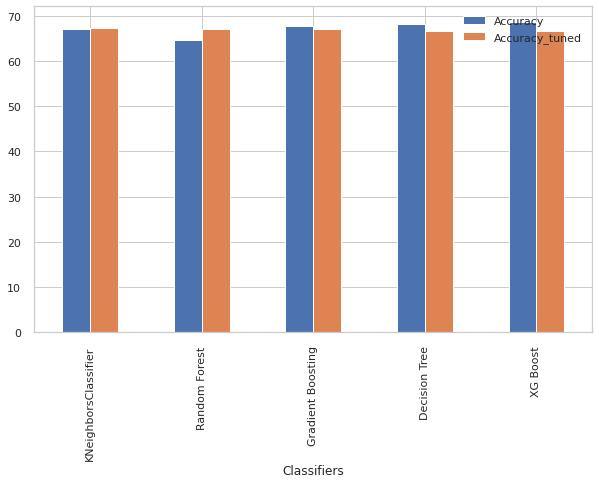

In [97]:
acc_table.sort_values("Accuracy_tuned",ascending=False).plot(x="Classifiers",
                y=["Accuracy","Accuracy_tuned"],
                kind="bar",
                figsize=(10,6))

## Feature impotance

In [ ]:
xgb_final_model.fit(X_train_transformed, y_train) 

XGBClassifier(learning_rate=0.01, max_depth=5, missing=nan, n_estimators=161,
              objective='multi:softprob')

In [ ]:
predict_test = xgb_final_model.predict(X_test_transformed)

In [ ]:
acc_xgb = acc_score(xgb_final_model,X_test_transformed, y_test, scoring='accuracy')
acc_xgb

0.6669047376118084

In [ ]:
xgb_feature_importance = xgb_final_model.feature_importances_
xgb_feature_importance 

array([0.02461467, 0.01115528, 0.00863392, 0.00718216, 0.01729907,
       0.01207016, 0.01870702, 0.01608872, 0.00818464, 0.02702071,
       0.01500821, 0.01552257, 0.03705075, 0.05168052, 0.01664945,
       0.01300695, 0.01881617, 0.00042025, 0.01688991, 0.        ,
       0.        , 0.        , 0.        , 0.02110962, 0.        ,
       0.20758636, 0.08750139, 0.00805732, 0.        , 0.01770721,
       0.        , 0.        , 0.01804804, 0.01059375, 0.        ,
       0.12258548, 0.0204109 , 0.03466636, 0.08809322, 0.02763926],
      dtype=float32)

In [ ]:
categorical = list(full_pipeline.named_transformers_['cat'].get_feature_names_out())

In [ ]:
attributes = numerical + categorical

In [ ]:
df_import = pd.DataFrame(sorted(zip(xgb_feature_importance,attributes),reverse=True))

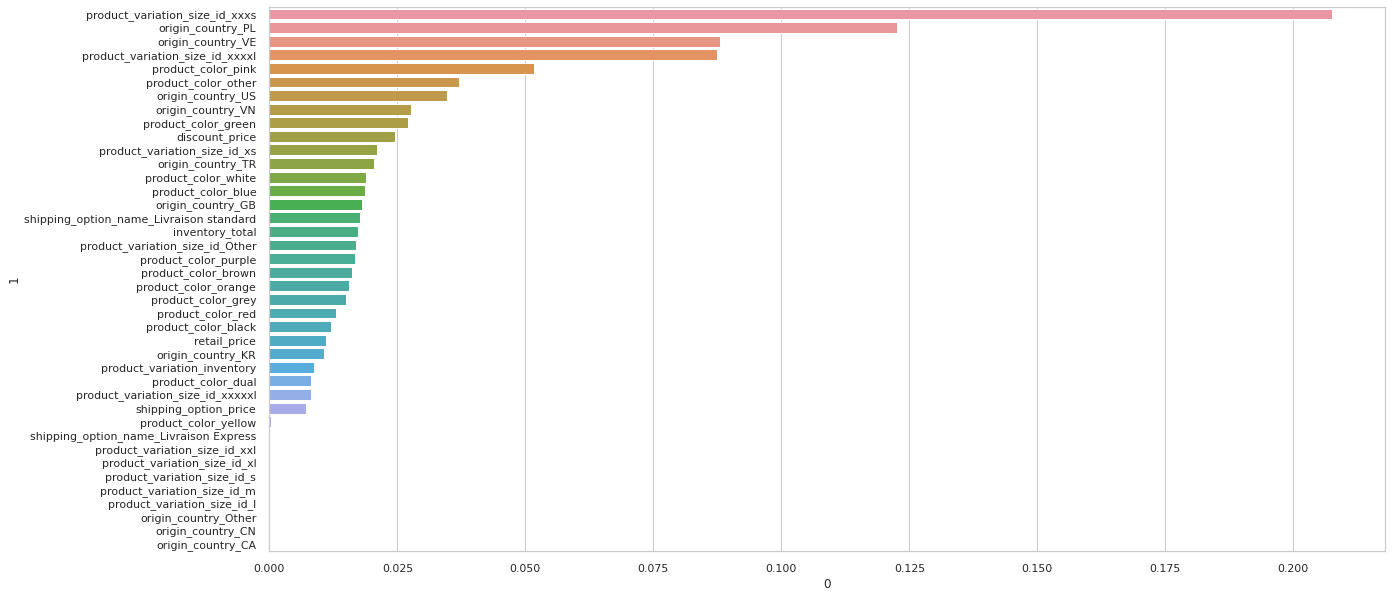

In [ ]:
plt.figure(figsize= (20,10))
sns.barplot(data = df_import, x= 0, y= 1)

<BarContainer object of 9 artists>

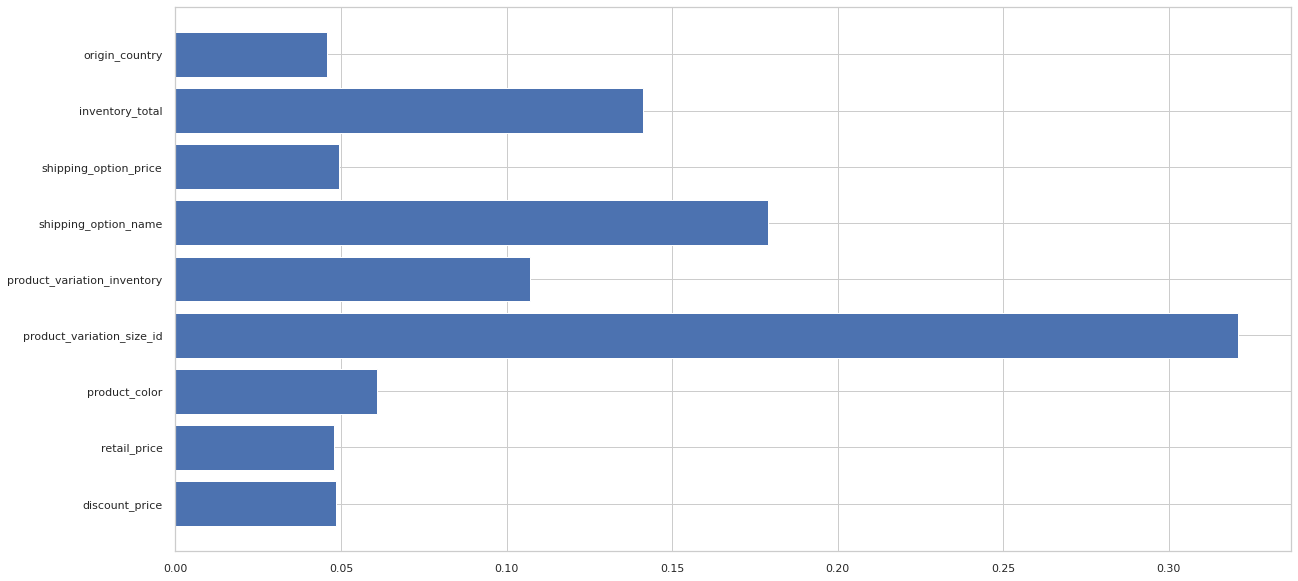

In [ ]:
plt.figure(figsize= (20,10))
plt.barh(x_train.columns, xgb_final_model.feature_importances_)

In [ ]:
# Define a function to select the indices of the top k feature importances
def indices_of_top_k(arr, k):
    # Your code here
    return np.sort(np.argpartition(np.array(arr),-k)[-k:])

In [ ]:
k =9

In [ ]:
top_k_feature_indices = indices_of_top_k(xgb_feature_importance, k)
top_k_feature_indices

array([ 9, 12, 13, 25, 26, 35, 37, 38, 39])

In [ ]:
np.array(attributes)[top_k_feature_indices]

array(['product_color_green', 'product_color_other', 'product_color_pink',
       'product_variation_size_id_xxxs',
       'product_variation_size_id_xxxxl', 'origin_country_PL',
       'origin_country_US', 'origin_country_VE', 'origin_country_VN'],
      dtype='<U39')

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # YOUR CODE HERE
        self.feature_index_ = indices_of_top_k(self.feature_importances, self.k)
        return X[:,self.feature_index_]

In [ ]:
# The pipeline should have the full pipeline and the top feature selectors you wrote above
#
preparation_and_feature_selection_pipeline = Pipeline([
                                                       ("preparation",full_pipeline),
                                                       ("feature_selection",TopFeatureSelector(xgb_feature_importance,k))
])

In [ ]:
top_k_features = preparation_and_feature_selection_pipeline.fit_transform(x_train)

In [ ]:
top_k_features[0:3]

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 1.96649934e-04, 1.00000000e+00, 1.25000000e-02,
        1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 5.12432192e-04, 2.00000000e-01, 3.75000000e-02,
        1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 2.00729808e-04, 1.00000000e-01, 1.25000000e-02,
        1.00000000e+00]])

In [ ]:
X_train_transformed[0:3, top_k_feature_indices]

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 1.96649934e-04, 1.00000000e+00, 1.25000000e-02,
        1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 5.12432192e-04, 2.00000000e-01, 3.75000000e-02,
        1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 2.00729808e-04, 1.00000000e-01, 1.25000000e-02,
        1.00000000e+00]])

In [ ]:

xgb_prepare_select_and_predict_pipeline = Pipeline([
                                                ("preparation",full_pipeline),
                                                ("feature_selection",TopFeatureSelector(xgb_feature_importance,k)),
                                                ("model_lgbm",xgb_final_model)
])

In [ ]:
xgb_prepare_select_and_predict_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preparation',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['product_color',
                                                   'product_variation_size_id',
                                                   'shipping_option_name',
                                                   'origin_country']),
                                                 ('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=1,
                                              

In [ ]:
some_data = x_train.iloc[:4]
some_labels = y_test.iloc[:4]

print("Predictions: ", xgb_prepare_select_and_predict_pipeline.predict(some_data))
print("Labels: ", list(some_labels))

Predictions:  [1000.  100.  100.  100.]
Labels:  [100.0, 10000.0, 100.0, 100.0]
